In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import jieba

#忽略警告
import warnings
warnings.filterwarnings("ignore")

### 数据预处理部分

In [118]:
#导入螺蛳粉评论的数据
comment1 = pd.read_csv('result.csv')
comments = pd.read_csv('李子柒螺蛳粉评论.csv')

# 把两个表格合并，并且重新设置索引
comments1 = comments.append(comment1)
comments1.index = range(len(comments1))
#去合并表格的重复值
comments1.drop_duplicates(inplace=True)
#去重复值
# print('comments表去重前的数据长度：',len(comments))

comments.drop_duplicates(inplace=True)
# print('comments表去重后的数据长度：',len(comments))

# print('comment1表去重前的数据长度：',len(comment1))
comment1.drop_duplicates(inplace=True)
# print('comments表去重后的数据长度：',len(comments))

comments1


,UserNick,comment_time,content,auctionSku
0,太***4,2020-04-09 18:53:48,整体评价：还不错呦，东西蛮好的，第一次买李子柒家东西呀，不错呀，棒棒哒 胀包问题：没有呀，包...,口味:螺蛳粉3袋装
1,秘***0,2020-04-10 13:33:19,＃柒家美拍达人＃当吃到李子柒家第一口螺狮粉的时候，只想说，漫长的等待是值得的😁米粉爽滑Q弹，...,口味:螺蛳粉3袋装
2,m***3,2020-04-11 16:57:29,整体评价：不错 胀包问题：无 包装品质：好 口感味道：辣椒半包就够了，挺香的 新鲜度：可以 ...,口味:螺蛳粉3袋装
3,爱***6,2020-04-10 17:52:28,#柒家美拍达人# 等待了好久的美食终于到了，可以说期待了很久，拿到后激动了很久，想着一定给柒...,口味:螺蛳粉3袋装
4,t***2,2020-04-11 18:39:50,3 月11 号下单，4月11 号收到的，哈哈哈哈 不愧是我等了一个月的螺蛳粉，好吃到爆炸！！...,口味:螺蛳粉3袋装
...,...,...,...,...
3975,g***儿,2021/5/14 22:49,已经买了好几次了，还是一如既往的好吃😋,口味:【鲜辣酸爽烫 】 螺蛳粉335g*3袋
3976,春***娴,2021/5/11 11:55,包装完美，好吃不贵！,口味:【鲜辣酸爽烫 】 螺蛳粉335g*3袋
3977,曹***0,2021/5/10 20:48,喜欢喜欢，符合我的口味👍,口味:【鲜辣酸爽烫 】 螺蛳粉335g*3袋
3978,t***3,2021/5/7 10:48,整体评价：好。 胀包问题：无 包装品质：严实，很好。 口感味道：酸辣可口，希望酸笋多一点会更喜欢！,口味:【鲜辣酸爽烫 】 螺蛳粉335g*3袋


In [119]:
#做出表中的评论的时间数量图

#将comment_time那列转化为datatime格式
comments1['comment_time'] = pd.to_datetime(comments1['comment_time'])

#将时间段去掉，只保留年月日

comments1['comment_date'] = comments1['comment_time'].dt.date

time_date = comments1['comment_date'].value_counts().sort_index()
# time_date.head(10)
# #观察一下末尾10条数据
# time_date.tail(10)


In [120]:
from pyecharts.charts import Line 
from pyecharts import options as opts 

#画出月份的时间图
line1 = Line(init_opts=opts.InitOpts(width='1000px', height='500px'))  # 初始化配置，画布的长度和高度
line1.add_xaxis(time_date.index.tolist())  # 用np库把时间表的index转化成列表形式,传入做为x横坐标
line1.add_yaxis('热度', time_date.values.tolist(),  # 图例， y轴数据，
                areastyle_opts=opts.AreaStyleOpts(opacity=0.5),   #图形透明度
                label_opts=opts.LabelOpts(is_show=True))
line1.set_global_opts(title_opts=opts.TitleOpts(title='商品评价数量走势图'), 
                      xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate='30')),  #x轴刻度倾斜30度
#                       toolbox_opts=opts.ToolboxOpts(), # 右上角的组件设置
                      visualmap_opts=opts.VisualMapOpts(max_=350))  #视觉映射配置
line1.set_series_opts(linestyle_opts=opts.LineStyleOpts(width=3))
line1.render_notebook()

### 情感分析部分


In [121]:
# 情感分析
'''实现步骤：
    从以下几个角度对评论进行分析：品牌、物流、包装、产品原料、食用口感、保质期、性价比等几个方面进行分析
    用一个新表格，对情感正负面打分并且把得分存进来。
    从上述几个角度分析，每个角度都建一个情感词库，遍历每个词库，找到评论中含有该词就进行打分
'''
# 创建一个函数，传进待处理的表格，进行情感打分统计，最终返回打分好的表连接在原表后面
def set_comment(df, result):
    
    # 创建一个空表
    new_form = pd.DataFrame(np.zeros(13 * len(comments)).reshape(len(comments),13),
                      columns = ['品牌','物流正面','物流负面','包装正面','包装负面','原料正面',
                                 '原料负面','口感正面','口感负面','日期正面','日期负面',
                                 '性价比正面','性价比负面'])

    # 创建情绪表，包含正面情绪1，负面情绪0
    #创建品牌表
    brand = ['李子柒','子柒','小柒','李子七','小七']
    
    #创建快递表
    courier = ['物流','快递','配送','取货','送货']
    courier1 = ['快','不错','棒','满意','迅速']
    courier0 = ['慢','龟速','久','差']
    
    #创建包装表
    pack = ['包装','盒子','袋子','外观','胀包']
    pack1 = ['高端','大气','还行','完整','好','严实','紧','精致']
    pack0 = ['破','破损','瘪','简陋','丑','难看','漏气']
    
    #创建原料产品表
    product = ['米粉','汤','配料','腐竹','花生','酸笋']
    product1 = ['劲道','多','足','香','才','脆','nice']
    product0 = ['小','少','没']

    #创建口感表
    taste = ['口味','味道','口感','吃起来']
    taste1 = ['好','不错','浓鲜','十足','鲜','可以','喜欢','符合','适中']
    taste0 = ['不好','不行','不鲜']
    
    #创建保质期表
    shelf = ['保质期','日期','时间']
        
    #创建性价比表,price1表示正面情绪，price0表示负面情绪
    price1 = ['划算','便宜','赚了','囤货','超值','太值','物美价廉','实惠','性价比高','不贵']
    price0 = ['贵','不值','亏了','不划算','不便宜','不值']
    
    for i in range(len(result)):
        word = result[i]
        #李子柒的产品具有强IP属性，基本都是正面评价，这里不统计情绪，只统计提及次数
        for j in brand:
            if j in word:
                new_form.iloc[i]['品牌'] = 1

        #先判断是不是物流相关的         
        for j in courier:
            if j in word:
                #再判断是正面还是负面情感
                for k in courier1:
                    if k in word:
                        new_form.iloc[i]['物流正面'] = 1
                    for l in courier0:
                        if l in word:
                            new_form.iloc[i]['物流负面'] = 1
                      
        #先判断是不是包装相关的
        for j in pack:
            if j in word:
                #再判断是正面还是负面情感
                for k in pack1:
                    if k in word:
                        new_form.iloc[i]['包装正面'] = 1
                    for l in pack0:
                        if l in word:
                            new_form.iloc[i]['包装负面'] = 1
                            
        #产品原料情绪，判断是不是原料相关
        for j in product:
            if j in word:
                #再判断是正面还是负面情感
                for k in product1:
                    if k in word:
                        new_form.iloc[i]['原料正面'] = 1
                    for l in product0:
                        if l in word:
                            new_form.iloc[i]['原料负面'] = 1
                    
        #口感的情绪，判断是不是口感相关
        for j in taste:
            if j in word:
                #再判断是正面还是负面情感
                for k in taste1:
                    if k in word:
                        new_form.iloc[i]['口感正面'] = 1
                    for l in taste0:
                        if l in word:
                            new_form.iloc[i]['口感负面'] = 1

        #口感方面，有些是不需要出现前置词，消费者直接评价好吃难吃的，例如：
        if '难吃' in word or '不好吃' in word:
            new_form.iloc[i]['口感负面'] = 1
        elif '好吃' in word or '香' in word:
            new_form.iloc[i]['口感正面'] = 1
        
        #日期是不是新鲜，先判断词是不属于保质期，时间，日期
        for j in shelf:
            if j in word:
                if '新鲜' in word:
                    new_form.iloc[i]['日期正面'] = 1
                elif '久' in word or '长' in word:
                    new_form.iloc[i]['日期负面'] = 1
            #若是整条评论出现过期，直接归为负面。
            elif '过期' in word:
                new_form.iloc[i]['日期负面'] = 1

        #性价比，判断是在正面情绪
        for j in price1:
            if j in word: 
                new_form.iloc[i]['性价比正面'] = 1
            #判断是在负面情绪
            for k in price0:
                if k in word:
                    new_form.iloc[i]['性价比负面'] = 1
    
    final_result = pd.concat([df,new_form],axis = 1)   # 连接DF表和打分好的表，按行连

    return final_result

In [122]:
# 这里set_comment 的参数是 原来的表，和原来的表的评论。最后得出一个连接好新表
verdict1 = set_comment(comments, result=comments.content)
verdict2 = set_comment(comment1, result=comment1.content)
# 把两个表格重新合并。因为上面分别处理的两个数据集，所以为更好地进行情感分析，再合并一次
verdict  = verdict1.append(verdict2)
#重新设置索引
verdict.index = range(len(verdict))
verdict

,UserNick,comment_time,content,auctionSku,品牌,物流正面,物流负面,包装正面,包装负面,原料正面,原料负面,口感正面,口感负面,日期正面,日期负面,性价比正面,性价比负面
0,太***4,2020-04-09 18:53:48,整体评价：还不错呦，东西蛮好的，第一次买李子柒家东西呀，不错呀，棒棒哒 胀包问题：没有呀，包...,口味:螺蛳粉3袋装,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,秘***0,2020-04-10 13:33:19,＃柒家美拍达人＃当吃到李子柒家第一口螺狮粉的时候，只想说，漫长的等待是值得的😁米粉爽滑Q弹，...,口味:螺蛳粉3袋装,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,m***3,2020-04-11 16:57:29,整体评价：不错 胀包问题：无 包装品质：好 口感味道：辣椒半包就够了，挺香的 新鲜度：可以 ...,口味:螺蛳粉3袋装,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,爱***6,2020-04-10 17:52:28,#柒家美拍达人# 等待了好久的美食终于到了，可以说期待了很久，拿到后激动了很久，想着一定给柒...,口味:螺蛳粉3袋装,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,t***2,2020-04-11 18:39:50,3 月11 号下单，4月11 号收到的，哈哈哈哈 不愧是我等了一个月的螺蛳粉，好吃到爆炸！！...,口味:螺蛳粉3袋装,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,g***儿,2021/5/14 22:49,已经买了好几次了，还是一如既往的好吃😋,口味:【鲜辣酸爽烫 】 螺蛳粉335g*3袋,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3956,春***娴,2021/5/11 11:55,包装完美，好吃不贵！,口味:【鲜辣酸爽烫 】 螺蛳粉335g*3袋,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3957,曹***0,2021/5/10 20:48,喜欢喜欢，符合我的口味👍,口味:【鲜辣酸爽烫 】 螺蛳粉335g*3袋,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3958,t***3,2021/5/7 10:48,整体评价：好。 胀包问题：无 包装品质：严实，很好。 口感味道：酸辣可口，希望酸笋多一点会更喜欢！,口味:【鲜辣酸爽烫 】 螺蛳粉335g*3袋,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [123]:
#对上表进行统计好评和差评。打上标签，便于后面的分类使用用

sum1 = verdict[['UserNick','物流正面','包装正面','原料正面','口感正面','日期正面','性价比正面']]
sum1['正面总分'] = sum1.iloc[:,1:6].sum(axis=1)    # 对正面的情绪进行求和，并加一列到sum1表后面

sum2 = verdict[['UserNick','物流负面','包装负面','原料负面','口感负面','日期负面','性价比负面']]
sum2['负面总分'] = sum2.iloc[:,1:6].sum(axis=1)    # 对负面的情绪进行求和，并加一列到sum2表后面

sum1['负面总分'] = sum2['负面总分']   #  在表sum1的后面加上负面总分这一列。 sum1表里就有了正、负面打分汇总两列

#进行打标签，如果正面总分大于负面总分，这判定为1，即好评。反之则为0
labels1 =  sum1.loc[lambda x:x['正面总分']>x['负面总分']]
labels1['label'] = 1
print('好评的总数：',len(labels1))
labels0 = sum1.loc[lambda x:x['正面总分']<=x['负面总分']]
labels0['label'] = 0
print('差评的总数：',len(labels0))

data_label= labels1.append(labels0)

data_label.index = range(len(data_label))


data_label = data_label[['UserNick','label']]

#把标签添加进去重的表格里面,只取公共部分，所以少了20条数据。这里合并好的数据只用与后面的分类，这个comments1不用于情感分析

comments1 = pd.concat([comments1,data_label],axis = 1,join = 'inner')
comments1.index = range(len(comments1))
comments1

好评的总数： 2892
差评的总数： 1068


,UserNick,comment_time,content,auctionSku,comment_date,UserNick,label
0,太***4,2020-04-09 18:53:48,整体评价：还不错呦，东西蛮好的，第一次买李子柒家东西呀，不错呀，棒棒哒 胀包问题：没有呀，包...,口味:螺蛳粉3袋装,2020-04-09,太***4,1
1,秘***0,2020-04-10 13:33:19,＃柒家美拍达人＃当吃到李子柒家第一口螺狮粉的时候，只想说，漫长的等待是值得的😁米粉爽滑Q弹，...,口味:螺蛳粉3袋装,2020-04-10,秘***0,1
2,m***3,2020-04-11 16:57:29,整体评价：不错 胀包问题：无 包装品质：好 口感味道：辣椒半包就够了，挺香的 新鲜度：可以 ...,口味:螺蛳粉3袋装,2020-04-11,m***3,1
3,爱***6,2020-04-10 17:52:28,#柒家美拍达人# 等待了好久的美食终于到了，可以说期待了很久，拿到后激动了很久，想着一定给柒...,口味:螺蛳粉3袋装,2020-04-10,爱***6,1
4,t***2,2020-04-11 18:39:50,3 月11 号下单，4月11 号收到的，哈哈哈哈 不愧是我等了一个月的螺蛳粉，好吃到爆炸！！...,口味:螺蛳粉3袋装,2020-04-11,t***2,1
...,...,...,...,...,...,...,...
3935,h***周,2021-05-10 11:48:00,配菜很多不错喜欢吃,口味:【鲜辣酸爽烫 】 螺蛳粉335g*3袋,2021-05-10,t***6,0
3936,欧***会,2021-05-19 11:18:00,刚买完就降价 这也太逗了吧,口味:【鲜辣酸爽烫 】 螺蛳粉335g*3袋,2021-05-19,t***6,0
3937,r***8,2021-05-12 16:32:00,买了几次了，味道真的很好,口味:【鲜辣酸爽烫 】 螺蛳粉335g*3袋,2021-05-12,x***咩,0
3938,l***1,2021-04-25 13:44:00,"MK肚子饿的时候不✂想做饭就煮煮螺蛳粉吃,📉有点甜,脆中带韧。分📈量足,很辣,换成有汤📭的也...",口味:【鲜辣酸爽烫 】 螺蛳粉335g*3袋,2021-04-25,j***n,0


In [124]:
#对前面情感打分的表进行结果汇总
#从verdict表中第四列，即品牌那一列开始取到末尾那列，并且在对每一行的各列值求和
rank = verdict.iloc[:,4:].sum().reset_index().sort_values(0,ascending=False)
rank.columns = ['分类', '提及次数']
rank['占比'] = rank['提及次数'] / rank['提及次数'].sum()   # 这里的占比是单个次数/总的次数
rank['类别'] = rank['分类'].str[:-2]  # 把类别这一列给补上，除了品牌没有类别

# 把分类中品牌的那一行的类别，再添加为“品牌”
rank.loc[0, '类别'] = '品牌'
rank

,分类,提及次数,占比,类别
7,口感正面,2840.0,0.428550,口感
3,包装正面,879.0,0.132639,包装
5,原料正面,804.0,0.121322,原料
0,品牌,706.0,0.106534,品牌
6,原料负面,488.0,0.073638,原料
11,性价比正面,261.0,0.039384,性价比
9,日期正面,217.0,0.032745,日期
1,物流正面,139.0,0.020975,物流
10,日期负面,77.0,0.011619,日期
8,口感负面,70.0,0.010563,口感


In [125]:
# 进行各个类别的汇总并排序
rank_number = rank.groupby('类别')['提及次数'].sum().sort_values(ascending=False)
# 把上面的结果转化成二维列表
data_pair = [list(z) for z in zip(rank_number.index,rank_number.values)]
data_pair

[['口感', 2910.0],
 ['原料', 1292.0],
 ['包装', 918.0],
 ['品牌', 706.0],
 ['性价比', 330.0],
 ['日期', 294.0],
 ['物流', 177.0]]

In [126]:
#接下来画图，结果数据可视化

from pyecharts.charts import Pie 

pie1 = Pie(init_opts=opts.InitOpts(width='800px', height='500px'))
pie1.add( 
        series_name="numbers",
        radius=["35%", "65%"], # 环的内，外半径
        data_pair=data_pair, #系列数据项
        label_opts=opts.LabelOpts(
            position="outside",  # 数据在圆圈外
            formatter="{a|{a}}{abg|}\n{hr|}\n {b|{b}: }{c}  {per|{d}%}  ",    #格式化程序
            background_color="#eee",   #背景颜色
            border_color="#aaa",     #边框颜色
            border_width=1,
            border_radius=4,
            rich={
                "a": {"color": "#999", "lineHeight": 22, "align": "center"},
                "abg": {
                    "backgroundColor": "#e3e3e3",
                    "width": "100%",
                    "align": "right",
                    "height": 22,
                    "borderRadius": [4, 4, 0, 0],
                },
                "hr": {
                    "borderColor": "#aaa",
                    "width": "100%",
                    "borderWidth": 0.5,
                    "height": 0,
                },
                "b": {"fontSize": 16, "lineHeight": 33},
                "per": {
                    "color": "#eee",
                    "backgroundColor": "#334455",
                    "padding": [2, 4],
                    "borderRadius": 2,
                },
            },
        ),
)
pie1.set_global_opts(legend_opts=opts.LegendOpts(pos_left="left", pos_top='25%',      #图例组件离容器左侧，上侧的距离
                                                 orient="vertical"),              #  图例列表的布局朝向，纵向
                     toolbox_opts=opts.ToolboxOpts(),    #右上角工具箱设置
                     title_opts=opts.TitleOpts(title='消费者关注占比分布'))
pie1.set_series_opts(
    tooltip_opts=opts.TooltipOpts(trigger="item", formatter="{a} <br/>{b}: {c} ({d}%)")   #   formatter表示 系列名，数据项名，数值，百分比
    )
pie1.render_notebook()

In [127]:
#计算各项情感的正面占总比例和负面总比例
#转换字符串，再判别是否包含“正”
list1 =rank[rank['分类'].str.contains('正')]  # 让rank表里面的正面评论都提出来，存到list1里面
list2 =rank[rank['分类'].str.contains('负')]

#连接只有正，负面评论的两个表，合并
list3 = pd.merge(list1,list2,left_on = '类别',right_on='类别')

# 把每行（每个类别）正，负面提及的数量求和，
list3['提及总数'] = list3['提及次数_x']+list3['提及次数_y']
list3["正面占总比例"] = list3['提及次数_x']/list3['提及总数']   # 计算正面占比
list3["负面占总比例"] = list3['提及次数_y']/list3['提及总数']
list3 = list3[['类别','提及总数','分类_x','提及次数_x','正面占总比例','分类_y','提及次数_y','负面占总比例']]   #把表的列从新排版次序
list3

,类别,提及总数,分类_x,提及次数_x,正面占总比例,分类_y,提及次数_y,负面占总比例
0,口感,2910.0,口感正面,2840.0,0.975945,口感负面,70.0,0.024055
1,包装,918.0,包装正面,879.0,0.957516,包装负面,39.0,0.042484
2,原料,1292.0,原料正面,804.0,0.622291,原料负面,488.0,0.377709
3,性价比,330.0,性价比正面,261.0,0.790909,性价比负面,69.0,0.209091
4,日期,294.0,日期正面,217.0,0.738095,日期负面,77.0,0.261905
5,物流,177.0,物流正面,139.0,0.785311,物流负面,38.0,0.214689


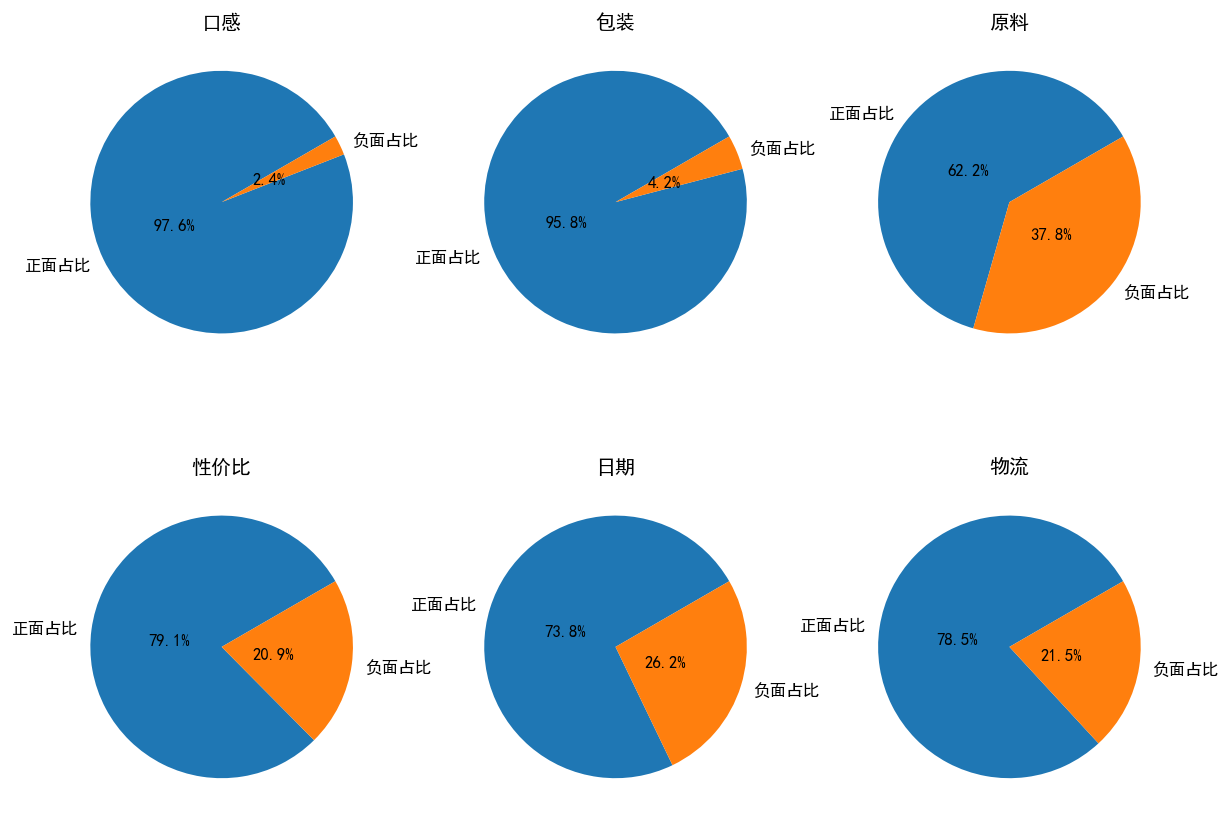

In [128]:
#画出各类别正负占比的饼图
import matplotlib.pyplot as plt
plt.rcParams['font.family']='SimHei'

# 定义类别图函数
def category():
    plt.figure(figsize=(12,9), dpi=120)
    j=231
    for i in list3.iterrows():
        x=i[1][[4,7]]     # i是多维元组类型，1表示表格，4表示下标第四列，7表示第7列
        labels = ['正面占比','负面占比']
        plt.subplot(j)          # 一个代表行数，第二个代表列数，第三个代表索引位置。总共两行，3列，位置从1到6
        plt.pie(x, labels=labels,autopct='%1.1f%%',pctdistance=0.4,startangle=30)
        plt.title(i[1][0])
        j+=1
    
    plt.show()
category()     

In [129]:
from pyecharts import options as opts
from pyecharts.charts import Bar
from pyecharts.globals import ThemeType

bar1 = Bar(init_opts=opts.InitOpts(width='1000px', height='400px', theme=ThemeType.LIGHT))
bar1.add_xaxis(['口感', '包装', '原料', '性价比',  '日期','物流'])
bar1.add_yaxis("正面评论", [i for i in list3['提及次数_x']], itemstyle_opts = opts.ItemStyleOpts(color='red'), category_gap="50%")
bar1.add_yaxis("负面评论", [i for i in list3['提及次数_y']], itemstyle_opts = opts.ItemStyleOpts(color='black'),category_gap="50%")
bar1.set_global_opts(title_opts=opts.TitleOpts(title='关注点细分正负情绪对比')) 
bar1.set_series_opts(label_opts=opts.LabelOpts(is_show=True))
bar1.render_notebook()

### 词频统计部分

In [130]:

#进行分词，并且统计关键词词频
import jieba 
import jieba.analyse 

# 连接所有评论，用句号做分隔符
txt = comments1['content'].str.cat(sep='。')

# 添加关键词，遇到“李子柒”不对它分词
jieba.add_word('李子柒')


#停用词表
stop_words =  ['的','怎么','而已','就','和','啊','呢','吗','了','呦','哟','#','啦','呀','这','那',
               ' ','40', 'hellip', '一袋', '一包', '一个月','螺丝','一点', '哈',
               '不过','但是','哈哈','一个','那种',
               '不是','终于','还是','时候','这个','时候','就是',
                   '螺狮粉', '螺蛳','$','，','。','？','！','...','：','；', '\n']


#这里先把词频前100的统计一下
# jieba.lcut() 精确模式切分中文
words = jieba.lcut(txt)
counts={}
for i in words:

    if i in stop_words or len(i) == 1:
        continue
    counts[i] = counts.get(i, 0)+1
items = list(counts.items())
items.sort(key=lambda x: x[1], reverse=True)



# 评论字段提取关键词，提取出来排名前100的关键词，以及关键词的权重，，并且不对词性过滤
#topK： 为返回几个 TF/IDF 权重最大的关键词
word_numbers = jieba.analyse.extract_tags(txt,topK=100,withWeight=True,
                                      allowPOS=())

# 去停用词
word_numbers_selected = []

for i in word_numbers:
    if i[0] not in stop_words:
        word_numbers_selected.append(i)

key_words = pd.DataFrame(word_numbers_selected, columns=['words','weight'])


#合并两个表格，词频数表和权重表
weight = pd.DataFrame(word_numbers_selected, columns=['words','weight'])
numbers = pd.DataFrame(items, columns=['words','numbers'])
new_keys = pd.merge(weight,numbers,left_on = 'words' ,right_on = 'words')
new_keys

,words,weight,numbers
0,味道,0.279488,2513
1,好吃,0.255029,2077
2,包装,0.155636,1368
3,口感,0.136525,946
4,李子柒,0.134128,740
...,...,...,...
81,欢螺,0.012144,67
82,好久,0.012111,94
83,朋友,0.012057,136
84,到货,0.011940,79


In [131]:
# 画词云图

from pyecharts.charts import WordCloud
from pyecharts.globals import SymbolType 


word1 = WordCloud(init_opts=opts.InitOpts(width='800px', height='600px'))
word1.add("", [*zip(new_keys.words, new_keys.numbers)],  #  根据词频数提取的词云图
          word_size_range=[20, 120],
          shape=SymbolType.DIAMOND)

word1.set_global_opts(title_opts=opts.TitleOpts('评论分布词云图'),
#                       toolbox_opts=opts.ToolboxOpts()
                     )
word1.render_notebook()

### 机器学习的文本分类部分

In [132]:
#导入已经打好标签的数据集，并且只取文本和标签两列。
#但是数据类别不平衡。这里可以采取的办法有数据层面的办法和算法层面的

'''类间不平衡：不同类别之间的数据量相差较大
    内在不平衡：由于数据本身导致的数据不平衡，即数据本身存在正负样例差
    绝对不平衡：由于正负样例之比较大，例如：正例10000个，负例100个，正负例之比为100：1，这种情况叫做相对不平衡。
'''

#数据层面的有欠采样，过采样，随机采样。算法层面的有代价敏感算法


dateframe = comments1[['content','label']]
# dateframe 
# comments1

#### 数据处理

In [133]:
# 查看数据的维度形状
print(dateframe.shape)
#将数据格式转换为字符串方便处理
dateframe['content'] = dateframe['content'].astype('str')

(3940, 2)


In [134]:
patten = r"[!\"#$%&'()*+,-./:;<=>?@[\\\]^_`{|}~—！，。？·￥、《》···【】：" "''\s0-9\U0001f60a\U00010000-\U0010ffff\uD800-\uDBFF\uDC00-\uDFFF]+"  # 标点符号和数字,表情
re_obj = re.compile(patten)
def clear(text):
    return re_obj.sub('', text)  #去除标点符号和数字，表情


dateframe['content'] = dateframe['content'].apply(clear)    #函数则会遍历每一个元素，对元素运行clear()
# dateframe.head(10)

In [135]:
def cut_words(words):
    return jieba.lcut(words)  # 使用lcut分词

dateframe['content'] = dateframe['content'].apply(cut_words)  #apply函数对series的每一行数据进行cut_words()处理
# dateframe

In [136]:
# 停用词处理直接用前面情感分析的停用词表
def remove_stop(words):  #移除停用词函数
    texts = []

    for word in words:  # 遍历列表里的每个词
        if word not in stop_words :  # 若不在停用词列表中就将结果追加至texts列表中
            texts.append(word)

    return texts


dateframe['content'] = dateframe['content'].apply(remove_stop)
# dateframe.head(10)

In [137]:
def list_str(content):
    return ' '.join(content)  #将列表元素转换为字符串

dateframe['content'] = dateframe['content'].apply(list_str)
dateframe.head(10)

,content,label
0,整体 评价 还 不错 东西 蛮 好 第一次 买 李子柒 家 东西 不错呀 棒棒 哒 胀 包 ...,1
1,＃ 柒家美 拍 达 人 ＃ 当 吃 到 李子柒 家 第一口 只想 说 漫长 等待 是 值得 ...,1
2,整体 评价 不错 胀 包 问题 无 包装 品质 好 口感 味道 辣椒 半包 就够 挺 香 新...,1
3,柒家美 拍 达 人 等待 好久 美食 到 可以 说 期待 很 久 拿到 后 激动 很 久 想...,1
4,月 号 下单 月 号 收到 哈哈哈哈 不愧 是 我 等 粉 好吃 到 爆炸 黄先生 从来不 ...,1
5,据说 粉 臭味 是 因酸笋 而 粉 汤 由 肉 骨头 熬成 此举 使 汤 清甜 与 鲜美 后...,1
6,整体 评价 材料 很足胀 包 问题 没 发现 胀 包 问题 包装 品质 包装 严密 口感 味...,1
7,太 好吃 绝对 是 我 吃 过 最 好吃 复购 好 多次 酸笋 木耳 酸豆角 腐竹 花生 料...,1
8,在 南宁 柳州 吃 过 粉 深深 爱 上 然后 一天 无意 中 在 淘宝 看到 李子柒 家 ...,1
9,等 一个多月 到货 没白 等 这么 长时间 味道 超级 赞吃 那么 多 粉 李子柒 家 最 ...,1


1    2872
0    1068
Name: label, dtype: int64


<AxesSubplot:>

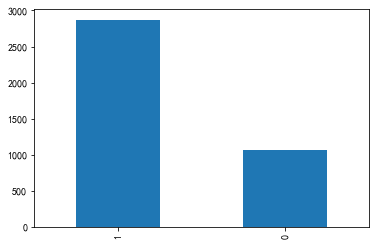

In [138]:
# 统计数据的标签，并且画出柱状图
print(dateframe['label'].value_counts())
dateframe['label'].value_counts().plot(kind='bar')

从上面的数据对比可以看出，样本存在严重的不均衡问题，这里考虑两种样本均衡的策略：

欠采样：正负样本各1000条，一共2000条

过采样：正负样本各1500条，一共3000条


#### 数据均衡

In [139]:
#进行过采样和欠采样处理，生成新数据
def get_balanced_words(size,
                       positive_comment=dateframe[dateframe['label'] == 1],  # 正面评论，标签为1
                       negtive_comment=dateframe[dateframe['label'] == 0]):  # 负面评论，标签为0
    
    word_size = size // 2
    
    num_pos = positive_comment.shape[0]       #获取原本旧的数据集中的 正 评论数
    num_neg = negtive_comment.shape[0]       #获取 负 评论数
    
    #     当 正(负)评论数中<采样数量/2 时，进行有放回采样，否则都是无放回采样；
    #     其中pandas的sample方法里的repalce参数代表是否进行有放回采样，默认则进行无放回抽样
    
    # pd.concat 用于连接正面的评论和负面的评论，上下连接而不是左右连接
    balanced_words = pd.concat([
         #正样本2872，负样本1068。所以正样本总是无放回抽样
        positive_comment.sample(word_size,                       
                                replace=num_pos < word_size,      # replace接收一个bool类型数据  ,当为表达式的结果为真时，则有放回抽样。
                                random_state=0),                 # random_state表示在同一个数据集上，前后抽样得到不同样的结果
        negtive_comment.sample(word_size,
                               replace=num_neg < word_size,       # 负样本1068个，size=3000时，则有放回抽样。
                               random_state=0)                    # 当欠采样时（总共2000条数据），不满足这个replace条件，不放回抽样。
    ])                                                            ##  当“replace=False”时，无法获取比总体更大的样本!
    #     打印样本个数
    print('样本总数：', balanced_words.shape[0])
    print('正样本数：', balanced_words[dateframe['label'] == 1].shape[0])
    print('负样本数：', balanced_words[dateframe['label'] == 0].shape[0])
    print('')
    return balanced_words

In [140]:
data_2000 = get_balanced_words(2000)
data_3000 = get_balanced_words(3000)


样本总数： 2000
正样本数： 1000
负样本数： 1000

样本总数： 3000
正样本数： 1500
负样本数： 1500



In [141]:
#查看5条数据
data_2000.head(5)

,content,label
1157,等 那么 久刚 拿到 手 迫不及待 煮 来 吃 煮法 很 简单 然后 爱 上 哈哈哈 吃 完...,1
399,整体 评价 包装 很 好看 比较 干净 口味 比较 咸 冲着 送 鼠标垫 份 上 给 好评 ...,1
2142,买 好 多次 真的 很 喜欢 味道 正宗 做 活动 买 很 划算 吃 完 再 购买 总之 喜...,1
670,整体 评价 赞 哦 胀 包 问题 也 没有 出现 胀 包 情况 包装 品质 整个 包装 也 ...,1
138,整体 评价 很大 满满的 料粉 女生 可以 够吃 男生 可能 不行 等 粉 到手 价格 贵 ...,1


In [142]:
#查看5条数据
data_3000.sample(5)

,content,label
3574,实物 一致 好棒 物流 超快,0
3749,难以忘怀 味道 家里人 都 爱 吃,0
2782,快递 速度 超给力 重点 是 好吃 味道 真的 不错 吃 完 再 来 补货,1
3532,好吃 喜欢 吃,0
1519,口感 味道 分 整体 评价 好 新鲜度 不错,1


#### 对2000的数据集进行训练建模

In [143]:
from sklearn.model_selection import train_test_split
#切分训练集和测试集，用75%做训练集、25%做测试集，二者采用相同的切分策略

x_train, x_test, y_train, y_test = train_test_split(data_2000['content'],     # 默认的test_size为25%
                                                    data_2000['label'],
                                                    random_state=1,    #固定随机种子，每次运行分的训练集和测试集都完全一样
                                                    shuffle=True)

In [144]:
#在正式建模之前，先将词转换成向量，即所谓的词嵌入。这里主要采用tf-idf方案:
#主要是，tf-idf对每个词进行处理得到的是一个概率向量，而word2vec得到的是概率矩阵，二者对后续的处理效率差异过大


from sklearn.feature_extraction.text import TfidfVectorizer  #原始文本转化为tf-idf的特征矩阵

tf_idf = TfidfVectorizer()

x_trian_vec = tf_idf.fit_transform(x_train)  #将训练集文本转换为向量

x_test_vec = tf_idf.transform(x_test)  #将测试集文本转换为向量

x_trian_vec.shape  #查看形状

(1500, 3288)

词向量处理后的特征维度过多，导致计算量巨大，而且一些tf-idf比较低的特征本身会对模型产生影响；为了消除这些负面影响，需要对特征进行精简，去掉一些特征。

In [145]:
#提前导入特征选择和建模需要的库
from sklearn.feature_selection import f_classif
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [146]:
#方差分析通过构建f 统计量（组内差异均值/组间差异均值），来选择与目标分类变量最相关的k个变量。
# 先将词向量进行转换float类型。后面送入以f 统计量作为选择标准的特征选择器中
x_trian_vec = x_trian_vec.astype(np.float64)  #转换为numpy的float类型，便于sklearn处理
x_test_vec = x_test_vec.astype(np.float64)

In [147]:
#特征维度太高，处理起来计算时间长，所以选择降维处理。SelectKBest能保存原来特征的维度下降
#f_calssif方法是用来计算两个特征之间的相关性
selector = SelectKBest(f_classif, k=min(400, x_trian_vec.shape[1]))  #选择器。f_classif：样本方差F值。k：计算前k位得分最高的特征

selector.fit(x_trian_vec, y_train)  #训练。运行记分函数并得到适当的特征

selected_x_trian = selector.transform(x_trian_vec)  # 转换x_train ，将 x_train 还原为所选特征 

selected_x_test = selector.transform(x_test_vec) # 转换x_test

print('selected_x_trian.shape  ',selected_x_trian.shape)
print('selected_x_test.shape   ',selected_x_test.shape)

selected_x_trian.shape   (1500, 400)
selected_x_test.shape    (500, 400)


In [148]:
#逻辑回归

from sklearn.linear_model import LogisticRegression  #导入逻辑回归模型
lr = LogisticRegression()

lr.fit(selected_x_trian, y_train)

y_lr = lr.predict(selected_x_test)

#打印训练集和测试集的f1值、recall等
print('lr测试集：', classification_report(y_test, y_lr))
print('lr测试集auc：', roc_auc_score(y_test, y_lr))

print()

print('lr训练集：', classification_report(y_train, lr.predict(selected_x_trian)))
print('lr训练集auc：', roc_auc_score(y_train, lr.predict(selected_x_trian)))

lr测试集：               precision    recall  f1-score   support

           0       0.70      0.78      0.74       245
           1       0.76      0.69      0.72       255

    accuracy                           0.73       500
   macro avg       0.73      0.73      0.73       500
weighted avg       0.73      0.73      0.73       500

lr测试集auc： 0.730892356942777

lr训练集：               precision    recall  f1-score   support

           0       0.78      0.87      0.82       755
           1       0.85      0.75      0.80       745

    accuracy                           0.81      1500
   macro avg       0.82      0.81      0.81      1500
weighted avg       0.82      0.81      0.81      1500

lr训练集auc： 0.8109471532068093


In [149]:
#xgb

from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=55, max_depth=4) # 为防止过拟合，采用较为少的树，以及决策树深度。基学习器的个数为55，树的深度为4

xgb.fit(selected_x_trian, y_train)

y_xgb = xgb.predict(selected_x_test)

print('xgboost测试集：', classification_report(y_test, y_xgb))
print('xgboost测试集auc：', roc_auc_score(y_test, y_xgb))

print()

print('xgboost训练集：', classification_report(y_train, xgb.predict(selected_x_trian)))
print('xgboost训练集auc：', roc_auc_score(y_train, xgb.predict(selected_x_trian)))

[14:51:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost测试集：               precision    recall  f1-score   support

           0       0.70      0.88      0.78       245
           1       0.85      0.63      0.72       255

    accuracy                           0.75       500
   macro avg       0.77      0.76      0.75       500
weighted avg       0.77      0.75      0.75       500

xgboost测试集auc： 0.7565026010404161

xgboost训练集：               precision    recall  f1-score   support

           0       0.83      0.96      0.89       755
           1       0.95      0.79      0.87       745

    accuracy                           0.88      1500
   macro avg       0.89      0.88      0.88      1500
weighted avg       0.89      0.8

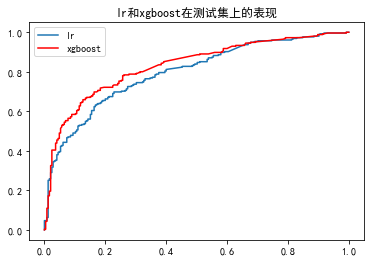

In [150]:
#绘制roc曲线
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体

fpr, tpr, thresholds = roc_curve(y_test,
                                 lr.predict_proba(selected_x_test)[:, 1],
                                 pos_label=1)
fpr_1, tpr_1, thresholds = roc_curve(y_test,
                                 xgb.predict_proba(selected_x_test)[:, 1],
                                 pos_label=1)   
plt.plot(fpr, tpr,label='lr')
plt.plot(fpr_1, tpr_1,color='red',label='xgboost')

plt.legend()
plt.title('lr和xgboost在测试集上的表现')
plt.show()

#### 对3000的数据集进行训练

In [151]:
# 3000的数据集进行建模
# 数据切分

x_train, x_test, y_train, y_test = train_test_split(data_3000['content'],
                                                    data_3000['label'],
                                                    random_state=1,
                                                    shuffle=True)

# 词向量化
tf_idf = TfidfVectorizer()
x_trian_vec = tf_idf.fit_transform(x_train)

x_test_vec = tf_idf.transform(x_test)

x_trian_vec = x_trian_vec.astype(np.float64)

x_test_vec = x_test_vec.astype(np.float64)

# 特征选择
selector = SelectKBest(f_classif, k=min(400, x_trian_vec.shape[1]))

selector.fit(x_trian_vec, y_train)

selected_x_trian = selector.transform(x_trian_vec)      #将 x_trian_vec 还原为所选特征

selected_x_test = selector.transform(x_test_vec)


#lr模型

lr.fit(selected_x_trian, y_train)

y_hat = lr.predict(selected_x_test)

print('lr测试集：',classification_report(y_test, y_hat))
print('lr测试集auc：', roc_auc_score(y_test, y_hat))
print()

print('lr训练集：',classification_report(y_train, lr.predict(selected_x_trian)))
print('lr训练集auc：', roc_auc_score(y_train, lr.predict(selected_x_trian)))

lr测试集：               precision    recall  f1-score   support

           0       0.77      0.80      0.79       379
           1       0.79      0.76      0.77       371

    accuracy                           0.78       750
   macro avg       0.78      0.78      0.78       750
weighted avg       0.78      0.78      0.78       750

lr测试集auc： 0.7811093173267715

lr训练集：               precision    recall  f1-score   support

           0       0.80      0.83      0.81      1121
           1       0.82      0.79      0.80      1129

    accuracy                           0.81      2250
   macro avg       0.81      0.81      0.81      2250
weighted avg       0.81      0.81      0.81      2250

lr训练集auc： 0.8076242346569911


In [152]:
#xgb模型
xgb.fit(selected_x_trian, y_train)
y_hat=xgb.predict(selected_x_test)  

print('xgboost测试集：',classification_report(y_test, y_hat))
print('xgboost测试集auc：', roc_auc_score(y_test, y_hat))
print()

print('xgboost训练集：',classification_report(y_train, xgb.predict(selected_x_trian)))
print('xgboost训练集auc：', roc_auc_score(y_train, xgb.predict(selected_x_trian)))

[14:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost测试集：               precision    recall  f1-score   support

           0       0.77      0.91      0.83       379
           1       0.88      0.73      0.80       371

    accuracy                           0.82       750
   macro avg       0.83      0.82      0.82       750
weighted avg       0.83      0.82      0.82       750

xgboost测试集auc： 0.8163595502421609

xgboost训练集：               precision    recall  f1-score   support

           0       0.83      0.94      0.88      1121
           1       0.94      0.80      0.86      1129

    accuracy                           0.87      2250
   macro avg       0.88      0.87      0.87      2250
weighted avg       0.88      0.8

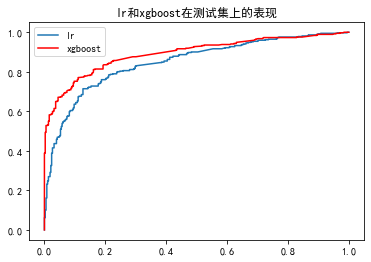

In [153]:
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体

fpr, tpr, thresholds = roc_curve(y_test,
                                 lr.predict_proba(selected_x_test)[:, 1],
                                 pos_label=1)
fpr_1, tpr_1, thresholds = roc_curve(y_test,
                                 xgb.predict_proba(selected_x_test)[:, 1],
                                 pos_label=1)   
plt.plot(fpr, tpr,label='lr')
plt.plot(fpr_1, tpr_1,color='red',label='xgboost')

plt.legend()
plt.title('lr和xgboost在测试集上的表现')
plt.show()

In [154]:
#xgb+lr模型

xgb.fit(selected_x_trian, y_train)

[14:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=55, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [155]:
xgb.apply(selected_x_trian).shape # apply方法将模型应用于数据，返回叶索引

(2250, 55)

In [156]:
xgb.apply(selected_x_test).shape

(750, 55)

In [157]:
# 一次将训练集和测试集特征组合结果转换为one_hot编码
all_leaf = np.concatenate(
    (xgb.apply(selected_x_trian), xgb.apply(selected_x_test)), axis=0) 
enc_leaf = OneHotEncoder()
enc_leaf.fit(all_leaf)
all_leaf = enc_leaf.transform(all_leaf)
all_leaf.shape

(3000, 439)

In [158]:

x_train_all = np.hstack((all_leaf[:2250, :].toarray(),
                         selected_x_trian.astype(np.float64).toarray()))
lr.fit(x_train_all, y_train)

print('训练集：',classification_report(y_train, lr.predict(x_train_all)))

print()

x_test_all = np.hstack((all_leaf[2250:, :].toarray(),
                        selected_x_test.astype(np.float64).toarray()))

print('测试集：',classification_report(y_test, lr.predict(x_test_all)))

训练集：               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1121
           1       0.97      0.85      0.91      1129

    accuracy                           0.91      2250
   macro avg       0.92      0.91      0.91      2250
weighted avg       0.92      0.91      0.91      2250


测试集：               precision    recall  f1-score   support

           0       0.78      0.91      0.84       379
           1       0.88      0.75      0.81       371

    accuracy                           0.83       750
   macro avg       0.83      0.83      0.83       750
weighted avg       0.83      0.83      0.83       750



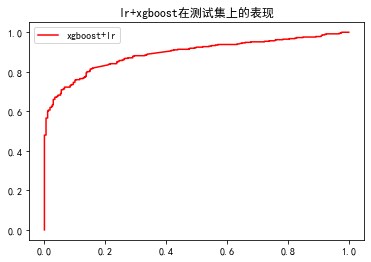

In [159]:
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体


# fpr, tpr, thresholds = roc_curve(y_test,
#                                  lr.predict_proba(x_test_all)[:, 1],
#                                  pos_label=1)
fpr_1, tpr_1, thresholds = roc_curve(y_test,
                                 lr.predict_proba(x_test_all)[:, 1],
                                 pos_label=1)  

# plt.plot(fpr, tpr,label='lr')
plt.plot(fpr_1, tpr_1,color='red',label='xgboost+lr')

plt.legend()
plt.title('lr+xgboost在测试集上的表现')
plt.show()

#### 用原来正负样本不平衡的数据集做对比
最后再来一个XGB来对比。用的最开始的打好标签数据集，没有经过采样的数据。

In [160]:
# 3940的数据集进行建模
# 数据切分

x_train, x_test, y_train, y_test = train_test_split(dateframe['content'],
                                                    dateframe['label'],
                                                    random_state=1,
                                                    shuffle=True)

# 词向量化
tf_idf = TfidfVectorizer()
x_trian_vec = tf_idf.fit_transform(x_train)

x_test_vec = tf_idf.transform(x_test)

x_trian_vec = x_trian_vec.astype(np.float64)

x_test_vec = x_test_vec.astype(np.float64)

# 特征选择
selector = SelectKBest(f_classif, k=min(400, x_trian_vec.shape[1]))

selector.fit(x_trian_vec, y_train)

selected_x_trian = selector.transform(x_trian_vec)      #将 x_trian_vec 还原为所选特征

selected_x_test = selector.transform(x_test_vec)


#lr模型

lr.fit(selected_x_trian, y_train)

y_hat = lr.predict(selected_x_test)

print('lr测试集：',classification_report(y_test, y_hat))
print('lr测试集auc：', roc_auc_score(y_test, y_hat))
print()

print('lr训练集：',classification_report(y_train, lr.predict(selected_x_trian)))
print('lr训练集auc：', roc_auc_score(y_train, lr.predict(selected_x_trian)))

lr测试集：               precision    recall  f1-score   support

           0       0.63      0.26      0.37       266
           1       0.78      0.94      0.85       719

    accuracy                           0.76       985
   macro avg       0.70      0.60      0.61       985
weighted avg       0.74      0.76      0.72       985

lr测试集auc： 0.6030671253934559

lr训练集：               precision    recall  f1-score   support

           0       0.77      0.35      0.48       802
           1       0.80      0.96      0.87      2153

    accuracy                           0.80      2955
   macro avg       0.78      0.66      0.68      2955
weighted avg       0.79      0.80      0.77      2955

lr训练集auc： 0.6566940173949705


In [161]:
#xgb模型
xgb.fit(selected_x_trian, y_train)
y_hat=xgb.predict(selected_x_test)  

print('xgboost测试集：',classification_report(y_test, y_hat))
print('xgboost测试集auc：', roc_auc_score(y_test, y_hat))
print()

print('xgboost训练集：',classification_report(y_train, xgb.predict(selected_x_trian)))
print('xgboost训练集auc：', roc_auc_score(y_train, xgb.predict(selected_x_trian)))

[14:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost测试集：               precision    recall  f1-score   support

           0       0.58      0.67      0.62       266
           1       0.87      0.82      0.85       719

    accuracy                           0.78       985
   macro avg       0.73      0.75      0.73       985
weighted avg       0.79      0.78      0.79       985

xgboost测试集auc： 0.7462693590722285

xgboost训练集：               precision    recall  f1-score   support

           0       0.70      0.78      0.74       802
           1       0.92      0.88      0.90      2153

    accuracy                           0.85      2955
   macro avg       0.81      0.83      0.82      2955
weighted avg       0.86      0.8

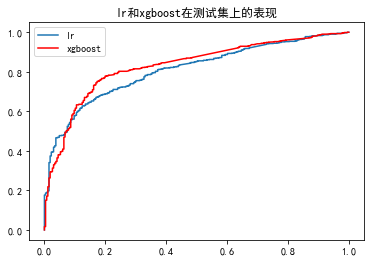

In [162]:
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体

fpr, tpr, thresholds = roc_curve(y_test,
                                 lr.predict_proba(selected_x_test)[:, 1],
                                 pos_label=1)
fpr_1, tpr_1, thresholds = roc_curve(y_test,
                                 xgb.predict_proba(selected_x_test)[:, 1],
                                 pos_label=1)   
plt.plot(fpr, tpr,label='lr')
plt.plot(fpr_1, tpr_1,color='red',label='xgboost')

plt.legend()
plt.title('lr和xgboost在测试集上的表现')
plt.show()

In [163]:
#'''对比之下，在用没有经过采样的数据集，训练出来的确实效果不佳'''